# Entrega 1, Grupo 02 - Arboles de decisión

- Santiago Alaniz, 5082647-6, santiago.alaniz@fing.edu.uy
- Bruno De Simone, 4914555-0, bruno.de.simone@fing.edu.uy
- Maria Usuca, , maria.usuca@fing.edu.uy



## 1. Objetivo

El objetivo de esta tarea es ahondar en la tematica de los arboles de decision. El dataset que vamos a considerar (con su debido preprocesamiento) es *"Predict students dropout and accademic success"* con 36 atributos y mas de 4000 instancias.

Se pide:

- **(a)** Implementar una variante del algoritmo `ID3` agregandole los siguientes *hiperparametros*:
    - **i)** `min_samples_split`: cantidad mínima de ejemplos para generar un nuevo nodo; en caso de que no se llegue a la cantidad requerida, se debe formar una hoja.
    - **ii)** `min_split_gain`: ganancia mínima requerida para partir por un atributo; si ningún atributo llega a ese valor, se debe formar una hoja.
- **(b)** Utilizar el algoritmo implementado en **(a)** para construir un arbol de decision, evaluar resultados utilizando el dataset provisto.
- **(c)** Discuta como afecta la variacion de los hiperparametros con los modelos obtenidos.
- **(d)** Corra los algoritmos de `scikit-learn` DecisionTreeClassifier, RandomForestClassifer y compare los resultados.


## 2. Diseño

El apartado de diseño engloba todas las decisiones que tomamos a la hora de cumplir los objetivos planteados en la sección anterior. Podemos identificar las siguientes etapas:

- **Carga de datos**: Inicializacion de los datos de los archivos CSV en un DataFrame de Pandas.
- **Tratamiento y Pre-procesamiento de datos**: Transformaciones necesarias para que los datos puedan ser utilizados por el algoritmo de aprendizaje a implementar.
- **Algoritmo**: Comentarios sobre la implementacion del algoritmo asi como las decisiones tomadas para su implementacion.
- **Evaluacion y Comparacion**: Evaluacion de los resultados obtenidos y su comparacion con los algoritmos mencionados en la letra.

### 2.0 Carga de datos.

Para cargar los datos vamos a usar la librería `pandas`, su formato *DataFrame* es verdaderamente versátil, nos permitira hacer un pre-procesamiento con `scikit-learn` de manera muy sencilla.

In [24]:
import pandas as pd

CSV_PATH = './assets/data.csv'

data = pd.read_csv(CSV_PATH, sep=';')
data.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### 2.1 Tratamiento y Preprocesamiento de datos

Para esta seccion hemos identificado las siguientes tareas a realizar:

1. Modificar la columna `Target` para que sea consistente con lo enunciado en la letra.
2. Preprocesar los atributos continuos de la tabla (discretizacion).
3. Particionar el conjunto de datos en dos: entrenamiento y prueba.

#### 2.1.1 Tratamiento del atributo objetivo `Target`.

El atributo objetivo `Target` es un atributo categorico que indica el desenlace del estudiante en su vida académica. Este atributo tiene 3 posibles valores: `Enrolled` (cursando), `Dropout`(abandono) y `Graduate`(graduado).

La idea es construir una hipotesis sobre la diserción de los estudiantes, por lo que se decide agrupar los valores `Enrolled` y `Graduate` en un solo valor. De esta forma:

-  0 &rarr; `Dropout`
-  1 &rarr; `Enrolled` o `Graduate`

Finalmente, siguiendo la notacion vista en el curso, renombramos el atributo de `Target` a `c(x)`

In [15]:
data['Target'] = data['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)
data = data.rename(columns={'Target': 'c(x)'})
data['c(x)'].value_counts()

c(x)
1    3003
0    1421
Name: count, dtype: int64

#### 2.1.2 Preprocesamiento de atributos continuos.

La [discretizacion](https://en.wikipedia.org/wiki/Data_binning) provee una forma de particionar valores continuos en un numero finito de valores discretos. De los [36 atributos presentes](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) en el dataset, hay 5 que son de naturaleza continua:

- `Previous qualification (grade)`
- `Admission grade`
- `Unemployment rate`
- `Inflation rate`
- `GDP`

Para discretizar estos atributos, utlizaremos el modulo de `preprocessing` de `scikit-learn`. En particular, utilizaremos la clase [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) con algunos* de sus meta-parametros por defecto (`n_bins=5`, `strategy='quantile'`, **).

Finalmente, identificar estos atributos en el dataset es una tarea sensilla, ya que son los unicos del tipo `float64`.

**Nota**: Hay un error en el documento de la tarea, ya que menciona que hay 5 atributos continuos, pero en realidad hay 7, `Curricular units 1st sem (grade)` y `Curricular units 2nd sem (grade)` se representan como `float64`.

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(encode='ordinal')
float_cols = data.select_dtypes(include=['float64']).columns

data[float_cols] = discretizer.fit_transform(data[float_cols]).astype(int)
print(data[float_cols].dtypes)
data[float_cols].head(5)

Previous qualification (grade)      int64
Admission grade                     int64
Curricular units 1st sem (grade)    int64
Curricular units 2nd sem (grade)    int64
Unemployment rate                   int64
Inflation rate                      int64
GDP                                 int64
dtype: object


,Previous qualification (grade),Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP
0,1,2,0,0,2,3,3
1,4,4,4,4,4,1,3
2,1,2,0,0,2,3,3
3,1,1,3,2,1,0,1
4,0,4,2,3,4,1,3


#### 2.1.3 Particion de datos.

En esta sección se separan los datos en dos conjuntos, uno de entrenamiento y otro de prueba. El conjunto de entrenamiento se utiliza para entrenar el modelo y el conjunto de prueba para evaluar el modelo. Se utiliza un 80% de los datos para entrenamiento y un 20% para prueba.

La idea es usar el conjunto de entrenamiento para derivar una función booleana que infiera una hipotesis sobre los datos. Luego, se utiliza el conjunto de prueba para evaluar la hipotesis y determinar su rendimiento.

In [17]:
from sklearn.model_selection import train_test_split

SEED_NUMBER = 42069

train, test = train_test_split(data, test_size=0.2, random_state=SEED_NUMBER)



## 2.2 Algoritmo


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from src.G02_algorithm import CustomID3Classifier
import matplotlib.pyplot as plt

X_train, y_train = train.drop(columns=['c(x)']), train['c(x)']

custom_clf = CustomID3Classifier(MIN_SAMPLES_SPLIT=0, MIN_SPLIT_GAIN=0)
custom_clf.fit(X_train, y_train)

Accuracy: 0.8564971751412429


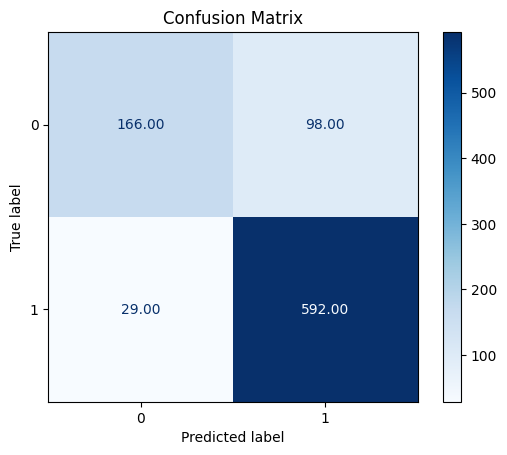

In [20]:
X_test, y_test = test.drop(columns=['c(x)']), test['c(x)']
predictions = custom_clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')

plt.title("Confusion Matrix")
plt.show()



## 2.3 Evaluación
- Qué conjunto de métricas se utilizan para la evaluación de la solución y su definición
- Sobre qué conjunto(s) se realiza el entrenamiento, ajuste de la solución, evaluación, etc. Explicar cómo se construyen estos conjuntos.

## 3. Experimentación

- Presentar los distintos experimentos que se realizan y los resultados que se obtienen.

- La información de los resultados se presenta en tablas y en gráficos, de acuerdo a su naturaleza. Por ejemplo:

_En la gráfica 1, se observa el error cuadrático total del conjunto de entrenamiento a medida que pasan los juegos para el oponente X_


- Debe existir alguna instancia donde se compile la información relevante de los experimentos de forma de poder comparar fácilmente los distintos experimentos. Por ejemplo:

_En la tabla 1, se presentan los distintos resultados contra el jugador aleatorio, para los distintos valores de $\alpha$ elegidos. El mejor resultado se obtiene para $\alpha=0.05$, lo que prueba que la estrategia..._

<table>
  <tr>
    <th>$\alpha$</th>
    <th>...</th>
    <th>Turnos</th>
    <th>Error</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>...</td>
    <td>100</td>
    <td>0.991</td>
  </tr>    
  <tr>
    <td>0.005</td>
    <td>...</td>
    <td>100</td>
    <td>0.987</td>
  </tr>
  <tr style="font-weight:bold">
    <td>0.05</td>
    <td>...</td>
    <td>100</td>
    <td>0.329</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>...</td>
    <td>100</td>
    <td>0.564</td>
  </tr>    
    <caption>Tabla 1 - Entrenamiento del jugador X para distintos valores de $\alpha$</caption>
</table>


## 4. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?